# Interannual variability at Moss Landing seawater intake

Analysis of water property anomalies since 2010. Data is available at http://seawater.mlml.calstate.edu

The csv files have been compiled and stored in NetCDF format, which can be easily loaded into an xarray Dataset (http://xarray.pydata.org/en/stable/). See readme file for details on how to automatically download all csv files and produce a NetCDF file. MLML physoce package is available at https://github.com/tompc35/physoce. 

In [15]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import xarray as xr
from physoce.graph import TS_contours
import mlml_data_path

### Load dataset

In [16]:
nc_dir = mlml_data_path.netcdf()
sw_nc = nc_dir + 'mlml_seawater.nc'
sw = xr.open_dataset(sw_nc)
sw.load()

<xarray.Dataset>
Dimensions:    (time: 524841)
Coordinates:
  * time       (time) datetime64[ns] 2010-09-03T17:11:59 2010-09-03T17:16:59 ...
    lon        float64 -121.8
    lat        float64 36.8
Data variables:
    ba         (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    ba_flg     (time) float64 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 ...
    cond       (time) float64 0.8658 0.8652 0.8651 0.8659 0.8665 0.8651 ...
    cond_flg   (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    do2        (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    do2_flg    (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    fluor      (time) float64 1.63 1.779 1.613 1.563 1.696 1.713 1.646 1.63 ...
    fluor_flg  (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    osat       (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    osat_flg   (time) float64 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 ...
    o

### QARTOD and calibration

Apply flags from QARTOD tests to all variables. Use only data flagged as 1 (*Pass; Data have passed critical real-time quality control tests and are deemed adequate for use as preliminary data*)

Calibration dates for C and T sensors are obtained from data readme file and maintenance log.

In [17]:
var_list = ['ba','cond','do2','fluor','osat','otemp','ph','sal','temp','trans']
for var in var_list:
    flagi = np.where(sw[var + '_flg'] != 1)
    sw[var][flagi] = np.nan
    
caldates_ts = np.array([datetime(2012,2,6),
                        datetime(2012,10,18,12),
                       datetime(2013,8,21,12),
                       datetime(2014,3,27,12),
                       datetime(2015,10,5)])

### Monthly climatology and anomalies

Calculate monthly means. Use monthly means to compute seasonal climatology. Subtract seasonal cycle to obtain monthly anomalies.

In [18]:
swm = sw.resample('1MS', dim='time', how='mean')
clim = swm.groupby('time.month').mean('time')
anom = swm.groupby('time.month') - clim

# Temperature variability (2010-2016)

<IPython.core.display.Javascript object>


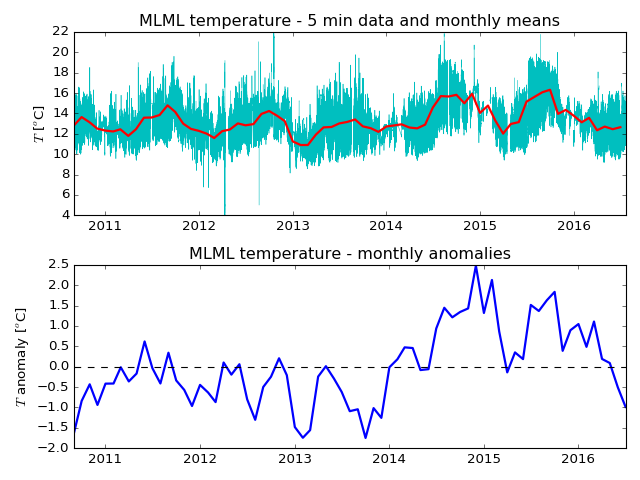

In [19]:
plt.figure()
plt.subplot(211)
plt.plot(sw['time'],sw['temp'],'c',lw=0.5)
plt.plot(swm['time'],swm['temp'],'r',lw=2)
plt.title('MLML temperature - 5 min data and monthly means')
plt.ylabel('$T$ [$^o$C]')

plt.subplot(212)
plt.plot(anom['time'],anom['temp'],lw=2)
plt.plot(np.array([anom['time'].values[0],
                   anom['time'].values[-1]]),
         np.array([0,0]),'k--')
plt.title('MLML temperature - monthly anomalies')
plt.ylabel('$T$ anomaly [$^o$C]')
plt.tight_layout()

# Salinity variability (2010-2016)

<IPython.core.display.Javascript object>


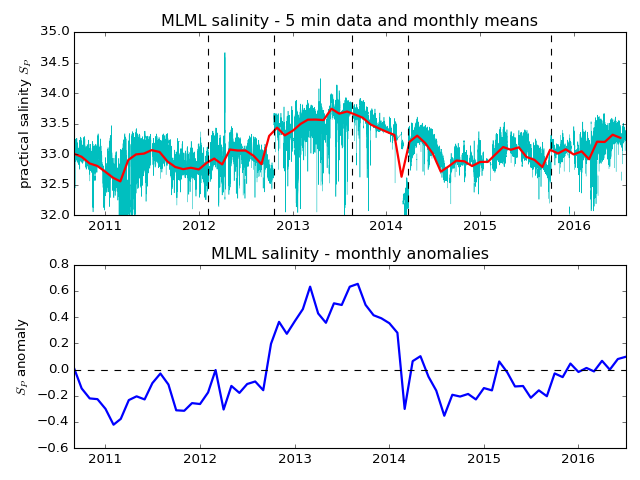

In [22]:
plt.figure()
plt.subplot(211)
plt.plot(sw['time'],sw['sal'],'c',lw=0.5)
plt.plot(swm['time'],swm['sal'],'r',lw=2)
yl = plt.ylim()
for d in caldates_ts:
    plt.plot([d,d],yl,'k--')
plt.title('MLML salinity - 5 min data and monthly means')
plt.ylabel('practical salinity $S_P$')

plt.subplot(212)
plt.plot(anom['time'],anom['sal'],lw=2)
plt.plot(np.array([anom['time'].values[0],
                   anom['time'].values[-1]]),
         np.array([0,0]),'k--')
plt.title('MLML salinity - monthly anomalies')
plt.ylabel('$S_P$ anomaly')
plt.tight_layout()

# Fall T-S properties

<IPython.core.display.Javascript object>


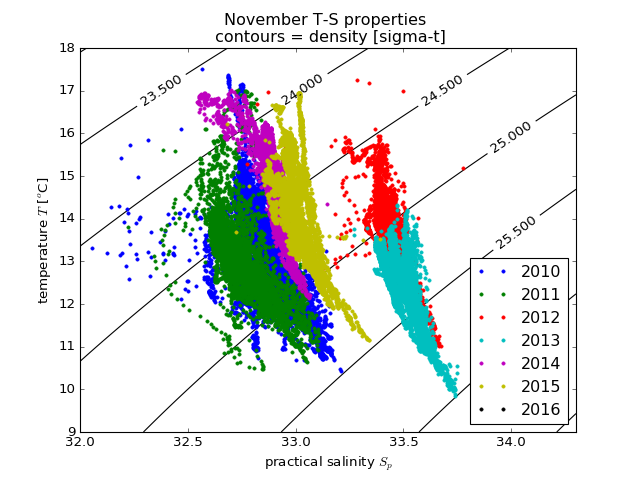

In [21]:
year_list = np.unique(sw['time.year'])

plt.close()
plt.figure()

month = 11
for year in year_list:
    gi = np.where((sw['temp_flg'] == 1) & 
                (sw['sal_flg'] == 1) & 
                (sw['time.year'] == year) & 
                (sw['time.month'] == month))
    plt.plot(sw['sal'][gi],sw['temp'][gi],'.')
    
c = TS_contours([32,34.3],[9,18],np.arange(20,30,0.5),colors='k')
plt.clabel(c)
plt.legend(year_list,loc='lower right')
plt.title('November T-S properties \n contours = density [sigma-t]')
plt.xlabel('practical salinity $S_p$')
plt.ylabel('temperature $T$ [$^o$C]')